# Pipeline for the anomaly detection on the SKAB using Feed Forward Autoencoder

In [4]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../utils')

## Data loading

In [5]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [6]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

## Data description and visualization

In [7]:
# dataset characteristics printing
print(f'A number of datasets in the SKAB v0.9: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SKAB v0.9: {n_cp}\n')
print(f'A number of outliers in the SKAB v0.9: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SKAB v0.9: 34

Shape of the random dataset: (1154, 10)

A number of changepoints in the SKAB v0.9: 129

A number of outliers in the SKAB v0.9: 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:14:36,0.027429,0.040353,0.770310,0.382638,71.2129,25.0827,219.789,32.0000,0.0,0.0
2020-03-09 12:14:37,0.027269,0.040226,1.096960,0.710565,71.4284,25.0863,233.117,32.0104,0.0,0.0
2020-03-09 12:14:38,0.027040,0.039773,1.140150,0.054711,71.3468,25.0874,234.745,32.0000,0.0,0.0
2020-03-09 12:14:39,0.027563,0.040313,1.108680,-0.273216,71.3258,25.0897,205.254,32.0104,0.0,0.0
2020-03-09 12:14:41,0.026570,0.039566,0.704404,0.382638,71.2725,25.0831,212.095,33.0000,0.0,0.0


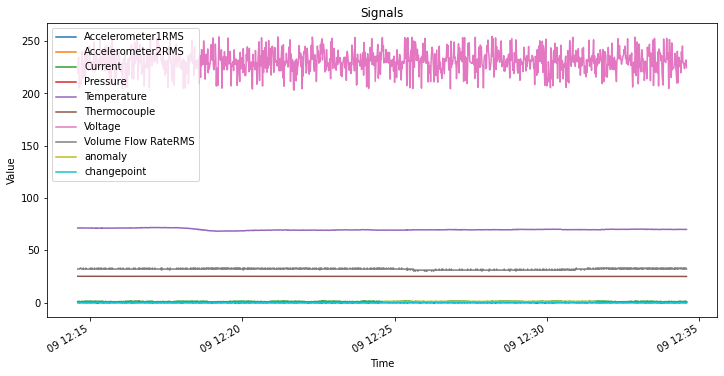

In [8]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Labels

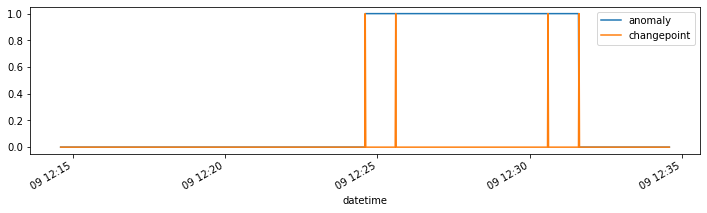

In [9]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,3))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [ ]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from itertools import product

In [ ]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [9]:
def arch(param, data):
    Random(0)
    input_dots = Input((8,))

    x = Dense(param[0])(input_dots)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(param[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    bottleneck = Dense(param[2], activation='linear')(x)

    x = Dense(param[1])(bottleneck)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(param[0])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    out = Dense(8, activation='linear')(x)

    model = Model(input_dots, out)
    model.compile(optimizer=Adam(param[3]), loss='mae', metrics=["mse"])
    
    early_stopping = EarlyStopping(patience=3, verbose=0)
    model.fit(data, data,
                validation_split=0.2,
                epochs=40,
                batch_size=param[4],
                verbose=0,
                shuffle=True,
                callbacks=[early_stopping]
               )
    return model

### Grid search for hyperparameters selection

In [10]:
# StSc = StandardScaler()

# # scaler fitting
# StSc.fit(X_train)

In [11]:
# n1=[6, 5]
# n2=[4, 3]
# n3=[2, 1]
# lr=[0.01, 0.005, 0.001]
# batch_size=[32, 64, 128]

# parameters = product(n1, n2, n3, lr, batch_size)
# parameters_list = list(parameters)
# print(f'Total number of parameter combinations: {len(parameters_list)}')

In [12]:
# pd.DataFrame(parameters_list, columns=['neurons 1st layer',
#                                       'neurons 2nd layer',
#                                       'neurons 3rd layer',
#                                       'learning rate',
#                                       'batch size'])

In [13]:
# errors = []
# for params in parameters_list:
    
#     model = arch(params, StSc.transform(X_train))
#     train_pred = model.predict(StSc.transform(X_train), batch_size=params[4])
#     val_pred = model.predict(StSc.transform(X_val), batch_size=params[4])
    
#     train_error = mean_absolute_error(StSc.transform(X_train), train_pred)
#     val_error = mean_absolute_error(StSc.transform(X_val), val_pred)
    
#     errors.append(list(params)+[train_error, val_error])
    
# df_errors = pd.DataFrame(errors,
#                          columns=['neurons 1st layer', 
#                                   'neurons 2nd layer', 
#                                   'neurons 3rd layer', 
#                                   'learning rate', 
#                                   'batch size', 
#                                   'mae train', 
#                                   'mae val'])
# df_errors.sort_values('mae val').head()

In [14]:
# best_params = parameters_list[df_errors.sort_values('mae val').index[0]]

# model = arch(best_params, StSc.transform(X_train))
# model.summary()

In [15]:
# val_residuals = StSc.transform(X_val) - model.predict(StSc.transform(X_val))
# train_residuals = StSc.transform(X_train) - model.predict(StSc.transform(X_train))

# UCL = abs(pd.DataFrame(val_residuals)).sum(axis=1).quantile(0.90)

### Training in the beginning of each dataset

In [16]:
# hyperparameters selection
BEST_PARAMS = [5, 4, 2, 0.005, 32]
Q = 0.99 # quantile for upper control limit (UCL) selection

In [17]:
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # model defining and fitting
    model = arch(BEST_PARAMS, StSc.transform(X_train))
    
    # results predicting
    residuals = pd.DataFrame(StSc.transform(X_train) - model.predict(StSc.transform(X_train))).abs().sum(axis=1)
    UCL = residuals.quantile(Q)
    
    df_sc = StSc.transform(df.drop(['anomaly','changepoint'], axis=1))
    ae_residuals = df_sc - model.predict(df_sc)
    ae = pd.DataFrame(ae_residuals).abs().sum(axis=1)
    
    prediction = pd.Series((ae > 3/2*UCL).astype(int).values, 
                                index=df.index).fillna(0)
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results

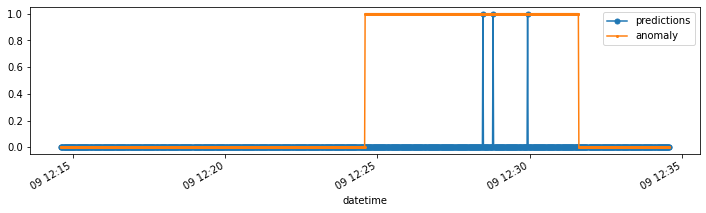

In [18]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

In [10]:
true_cp = [df.changepoint for df in list_of_df]
true_cp[0]

datetime
2020-03-09 12:14:36    0.0
2020-03-09 12:14:37    0.0
2020-03-09 12:14:38    0.0
2020-03-09 12:14:39    0.0
2020-03-09 12:14:41    0.0
                      ... 
2020-03-09 12:34:31    0.0
2020-03-09 12:34:32    0.0
2020-03-09 12:34:33    0.0
2020-03-09 12:34:34    0.0
2020-03-09 12:34:35    0.0
Name: changepoint, Length: 1154, dtype: float64

In [3]:
predicted_cp[0].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

NameError: name 'predicted_cp' is not defined

In [19]:
predicted_cp = true_cp[0].copy()

In [21]:
predicted_cp['2020-03-09 12:24:31'] = 1
predicted_cp['2020-03-09 12:25:52'] = 1
predicted_cp['2020-03-09 12:30:29'] = 1
predicted_cp['2020-03-09 12:31:42'] = 1

predicted_cp['2020-03-09 12:24:36'] = 0
predicted_cp['2020-03-09 12:25:36'] = 0
predicted_cp['2020-03-09 12:30:36'] = 0
predicted_cp['2020-03-09 12:31:36'] = 0

In [14]:
predicted_cp[predicted_cp==1]

datetime
2020-03-09 12:24:36    1.0
2020-03-09 12:25:36    1.0
2020-03-09 12:30:36    1.0
2020-03-09 12:31:37    1.0
Name: changepoint, dtype: float64

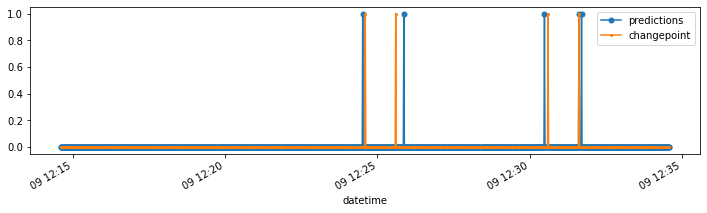

In [22]:
# true changepoint indices selection
# true_cp = [df.changepoint for df in list_of_df]

predicted_cp.plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Metrics calculation

In [ ]:
from tsad.evaluating.evaluating import evaluating

In [20]:
# binary classification metrics calculation
binary = evaluating(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 7.56 %
Missing Alarm Rate 66.57 %
F1 metric 0.45


In [21]:
# average detection delay metric calculation
add = evaluating(true_cp, predicted_cp, metric='average_time', numenta_time='30 sec')

Average delay 0 days 00:00:06.394736842
A number of missed CPs = 92


In [22]:
# nab metric calculation
nab = evaluating(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 16
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 18
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 19
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 23
Intersection of the windows of too wide widths for dataset 27
Intersec

## [Additional] localization